<a href="https://colab.research.google.com/github/09334677600f/Code-for-Chapter-4/blob/main/%D9%85%D8%AF%D9%84_%D9%87%D8%A7%DB%8C_%D8%AA%D8%AD%D9%84%DB%8C%D9%84_%D8%A8%D9%82%D8%A7_(%D8%A8%D8%AE%D8%B4_%D8%AF%D9%88%D9%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel("/content/final_file1 (2).xlsx")

In [ ]:
# نمایش چند سطر اول
print(df.head())

     ID  Accident_ID  تعداد تصادف       تاریخ جنسیت           زمان تماس  \
0  1974         2973            1  1396/02/01  مذکر 1900-01-01 00:30:47   
1  1975         2974            1  1396/02/01  مذکر 1900-01-01 01:53:47   
2  1976         2975            1  1396/02/01  مذکر 1900-01-01 03:45:52   
3  1977         2976            1  1396/02/01  مذکر 1900-01-01 06:07:41   
4  1978         2977            0  1396/02/01  مذکر 1900-01-01 07:16:55   

  ساعت رسیدن به محل حادثه  سن بیمار   مدت زمان  وضعیت زمان شب و روز  \
0     1900-01-01 00:39:57       1.0   9.166667      0            شب   
1     1900-01-01 02:04:26      53.0  10.650000      0            شب   
2     1900-01-01 03:55:44      26.0   9.866667      0            شب   
3     1900-01-01 06:23:18      35.0  15.616667      0           روز   
4     1900-01-01 07:24:55      73.0   8.000000      1           روز   

  ساعت اوج ترافیک   نوع روز   فصل  
0     خارج از اوج  آخر هفته  بهار  
1     خارج از اوج  آخر هفته  بهار  
2     خارج از 

In [ ]:

"""
Random Intercept Accelerated Failure Time Model
for Emergency Response Data (Weibull & LogNormal)
Censoring: durations > 8 minutes
"""

# --------------------------------------------------------------
# 1. Libraries
# --------------------------------------------------------------
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import lognorm, weibull_min
from scipy.special import gamma

# --------------------------------------------------------------
# 2. Data Preparation
# --------------------------------------------------------------


# --- حذف ستون‌های غیرضروری ---
columns_to_drop = [
    "ID", "Accident_ID", "تعداد تصادف",
    "زمان تماس", "ساعت رسیدن به محل حادثه"
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)

# --- انتخاب X و y ---
X_cols = ["سن بیمار", "جنسیت", "زمان شب و روز", "نوع روز","فصل", "ساعت اوج ترافیک"]
X = df[X_cols].copy()
y = df[["مدت زمان", "وضعیت"]].copy()

# --- پیش‌پردازش ---
categorical_cols = ["جنسیت", "زمان شب و روز", "نوع روز", "فصل", "ساعت اوج ترافیک"]
X_categorical = pd.get_dummies(X[categorical_cols], drop_first=True)

scaler = StandardScaler()
X_numeric = pd.DataFrame(scaler.fit_transform(X[["سن بیمار"]]), columns=["سن بیمار"], index=X.index)

X_processed = pd.concat([X_numeric, X_categorical], axis=1)

# --- گروه‌بندی تاریخ‌ها ---
date_col = df["تاریخ"].copy()
group_factor, _ = pd.factorize(date_col)
group_factor = group_factor.astype(np.int32)

# --- تقسیم داده ---
X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
    X_processed, y, group_factor, test_size=0.2, random_state=42, stratify=y["وضعیت"]
)

# --- اطمینان از عددی بودن همه ورودی‌ها ---
X_train = X_train.apply(pd.to_numeric, errors='coerce').astype(float)
y_train["مدت زمان"] = pd.to_numeric(y_train["مدت زمان"], errors='coerce')
y_train["وضعیت"] = pd.to_numeric(y_train["وضعیت"], errors='coerce')

print(f"تعداد نمونه کل: {len(df)}")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# --------------------------------------------------------------
# 3. Training Data Setup
# --------------------------------------------------------------
t_train = np.where(y_train["وضعیت"] == 1, y_train["مدت زمان"].values, 8.0)
observed = (y_train["وضعیت"] == 1).values
unique_groups = np.unique(g_train)
n_groups = len(unique_groups)

# --------------------------------------------------------------
# 4. Helper function for AIC, MAE, MAPE
# --------------------------------------------------------------
def evaluate_aft(distribution_name, trace, X_train, g_train, y_train, t_train, observed, n_groups):
    summary = az.summary(trace, kind="stats")
    mean_vals = summary["mean"].to_dict()

    beta_hat = np.array([mean_vals[f"beta[{i}]"] for i in range(X_train.shape[1])])
    mu_hat = mean_vals["mu"]
    sigma_hat = mean_vals["sigma"]
    b_hat = np.array([mean_vals[f"b[{i}]"] for i in range(n_groups)])

    lin_pred = mu_hat + X_train @ beta_hat + b_hat[g_train]

    # ---- AIC ----
    if distribution_name == "lognormal":
        scale = np.exp(lin_pred)
        logpdf = lognorm.logpdf(t_train[observed], s=sigma_hat, scale=scale[observed])
        logsf = lognorm.logsf(t_train[~observed], s=sigma_hat, scale=scale[~observed])
    elif distribution_name == "weibull":
        alpha = np.exp(lin_pred)
        kappa = sigma_hat
        logpdf = weibull_min.logpdf(t_train[observed], c=kappa, scale=alpha[observed])
        logsf = weibull_min.logsf(t_train[~observed], c=kappa, scale=alpha[~observed])
    else:
        raise ValueError("Unknown distribution")

    logL = np.sum(logpdf) + np.sum(logsf)
    k = X_train.shape[1] + 3 + n_groups
    aic = 2 * k - 2 * logL

    # ---- MAE / MAPE ----
    if distribution_name == "lognormal":
        pred_mean = np.exp(lin_pred + (sigma_hat**2) / 2)
    elif distribution_name == "weibull":
        pred_mean = np.exp(lin_pred) * gamma(1 + 1 / sigma_hat)

    obs_idx = (y_train["وضعیت"] == 1).values
    valid_idx = y_train["مدت زمان"].values[obs_idx] > 1.0
    mae = mean_absolute_error(y_train["مدت زمان"].values[obs_idx][valid_idx],
                              pred_mean[obs_idx][valid_idx])
    mape = mean_absolute_percentage_error(y_train["مدت زمان"].values[obs_idx][valid_idx],
                                          pred_mean[obs_idx][valid_idx])

    return aic, mae, mape



# --------------------------------------------------------------
# 6. مدل AFT با Random Intercept (Weibull) - اصلاح‌شده
# --------------------------------------------------------------
with pm.Model() as weibull_aft:
    # --- shared inputs to avoid shape/index errors ---
    X_shared = pm.Data("X_shared", X_train.values)  # (n_samples, n_features)
    g_shared = pm.Data("g_shared", g_train)         # (n_samples,)

    # --- priors ---
    mu = pm.Normal("mu", 0, 10)
    beta = pm.Normal("beta", 0, 10, shape=X_train.shape[1])
    k = pm.HalfNormal("k", 5)         # shape parameter
    # expose k also as "sigma" so evaluate_aft can read summary["sigma"]
    pm.Deterministic("sigma", k)

    tau = pm.HalfNormal("tau", 5)
    b = pm.Normal("b", 0, tau, shape=n_groups)

    # --- linear predictor and scale ---
    lin_pred = mu + pm.math.dot(X_shared, beta) + b[g_shared]   # shape = (n_samples,)
    lam = pm.math.exp(lin_pred)

    # --- likelihood for observed (non-censored) ---
    pm.Weibull("obs", alpha=k, beta=lam[observed], observed=t_train[observed])

    # --- censoring: S(t) = exp(-(t/λ)^k) ---
    if np.any(~observed):
        ratio = t_train[~observed] / lam[~observed]
        survival = pm.math.exp(-(ratio ** k))
        pm.Potential("cens", pm.math.log(survival))

    # --- sampling (store in trace_weibull) ---
    trace_weibull = pm.sample(1000, tune=1000, target_accept=0.95,
                              random_seed=42, chains=2, cores=1)



aic_wb, mae_wb, mape_wb = evaluate_aft("weibull", trace_weibull, X_train.values, g_train, y_train, t_train, observed, n_groups)

# --------------------------------------------------------------
# 7. Final Report
# --------------------------------------------------------------
print("\n" + "="*60)
print("📊 Random Intercept AFT Results")
print("="*60)
print(f"Total samples: {len(X_train)} | Groups (days): {n_groups}")

print("------ Weibull AFT ------")
print(f"AIC  : {aic_wb:.2f}")
print(f"MAE  : {mae_wb:.4f}")
print(f"MAPE : {mape_wb:.4f}")
print("="*60)

# --------------------------------------------------------------
# 7. Final Report with Parameter Estimates
# --------------------------------------------------------------

def print_parameter_estimates(trace, X_train, n_groups, model_name="Model"):
    summary = az.summary(trace, kind="stats")
    print(f"\n📌 Parameter estimates for {model_name}:\n")
    # mu
    print(f"mu     : {summary.loc['mu', 'mean']:.4f}")
    # beta
    for i, col in enumerate(X_train.columns):
        print(f"beta[{col}] : {summary.loc[f'beta[{i}]', 'mean']:.4f}")
    # sigma / kappa
    if 'sigma' in summary.index:
        print(f"sigma  : {summary.loc['sigma', 'mean']:.4f}")
    if 'kappa' in summary.index:
        print(f"kappa  : {summary.loc['sigma', 'mean']:.4f}")  # در مدل Weibull sigma همان kappa است
    # tau
    print(f"tau    : {summary.loc['tau', 'mean']:.4f}")
    # random intercepts b
    print("b (random intercepts per group):")
    for i in range(n_groups):
        print(f" b[{i}] : {summary.loc[f'b[{i}]', 'mean']:.4f}")


# چاپ نتایج Weibull
print_parameter_estimates(trace_weibull, X_train, n_groups, model_name="Weibull AFT")

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.120       63           6.04 draws/s     0:05:31   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.107       31           3.19 draws/s     0:10:26   0:00:00


📊 Random Intercept AFT Results
Total samples: 17682 | Groups (days): 294
------ Weibull AFT ------
AIC  : 42339.63
MAE  : 3.2630
MAPE : 0.7157

📌 Parameter estimates for Weibull AFT:

mu     : 2.3550
beta[سن بیمار] : -0.0060
beta[جنسیت_مونث] : 0.0060
beta[زمان شب و روز_شب] : 0.0130
beta[نوع روز_اول هفته] : 0.0220
beta[فصل_تابستان] : 0.1850
beta[فصل_زمستان] : -0.1390
beta[فصل_پاییز] : 0.0160
beta[ساعت اوج ترافیک_خارج از اوج] : -0.0650
sigma  : 3.2100
tau    : 0.0790
b (random intercepts per group):
 b[0] : 0.0460
 b[1] : -0.0350
 b[2] : -0.0240
 b[3] : -0.0700
 b[4] : -0.0500
 b[5] : 0.0670
 b[6] : 0.0590
 b[7] : -0.0150
 b[8] : -0.0130
 b[9] : -0.0130
 b[10] : -0.0160
 b[11] : -0.0370
 b[12] : -0.0110
 b[13] : 0.0550
 b[14] : 0.0460
 b[15] : 0.0100
 b[16] : -0.0210
 b[17] : -0.0230
 b[18] : 0.0370
 b[19] : 0.0120
 b[20] : 0.0380
 b[21] : -0.0480
 b[22] : 0.0160
 b[23] : -0.0370
 b[24] : -0.0780
 b[25] : -0.0240
 b[26] : 0.0240
 b[27] : 0.0210
 b[28] : -0.0020
 b[29] : -0.0310
 b[30] :

In [ ]:
# --------------------------------------------------------------
# 8. Evaluation on Test Data
# --------------------------------------------------------------
from math import pi, sin

def evaluate_test_data(distribution_name, trace, X_test, g_test, y_test, n_groups):
    """Compute mean predicted duration, MAE, and MAPE on test set."""
    summary = az.summary(trace, kind="stats")
    mean_vals = summary["mean"].to_dict()

    # استخراج پارامترهای میانگین از نمونه‌ها
    beta_hat = np.array([mean_vals[f"beta[{i}]"] for i in range(X_test.shape[1])])
    mu_hat = mean_vals["mu"]
    sigma_hat = mean_vals["sigma"]
    b_hat = np.array([mean_vals[f"b[{i}]"] for i in range(n_groups)])

    # داده‌ها را عددی و ایمن تبدیل کن
    X_test = X_test.apply(pd.to_numeric, errors='coerce').astype(float)
    g_test = np.array(g_test, dtype=int)
    y_test["مدت زمان"] = pd.to_numeric(y_test["مدت زمان"], errors='coerce')
    y_test["وضعیت"] = pd.to_numeric(y_test["وضعیت"], errors='coerce')

    # سانسور: بیشتر از 8 دقیقه
    t_test = np.where(y_test["وضعیت"] == 1, y_test["مدت زمان"].values, 8.0)
    observed_test = (y_test["وضعیت"] == 1).values

    # پیش‌بینی میانگین زمان بر اساس توزیع
    lin_pred_test = mu_hat + X_test.values @ beta_hat + b_hat[g_test]

    if distribution_name == "lognormal":
        pred_mean_test = np.exp(lin_pred_test + (sigma_hat**2) / 2)
    elif distribution_name == "weibull":
        pred_mean_test = np.exp(lin_pred_test) * gamma(1 + 1 / sigma_hat)
    else:
        raise ValueError("Unknown distribution")

    # فقط داده‌های غیرسانسور برای ارزیابی
    obs_idx_test = observed_test
    mae_test = mean_absolute_error(y_test["مدت زمان"].values[obs_idx_test],
                                   pred_mean_test[obs_idx_test])
    mape_test = mean_absolute_percentage_error(y_test["مدت زمان"].values[obs_idx_test],
                                               pred_mean_test[obs_idx_test])

    return mae_test, mape_test, pred_mean_test

# ارزیابی برای مدل Weibull
mae_wb_test, mape_wb_test, preds_wb = evaluate_test_data("weibull", trace_weibull, X_test, g_test, y_test, n_groups)

# --------------------------------------------------------------
# 9. گزارش نهایی
# --------------------------------------------------------------
print("\n" + "="*70)
print("📊 Final Evaluation on Test Data")
print("="*70)

print("------ Weibull AFT ------")
print(f"MAE (Test):  {mae_wb_test:.4f}")
print(f"MAPE (Test): {mape_wb_test:.4f}")
print("="*70)



📊 Final Evaluation on Test Data
------ Weibull AFT ------
MAE (Test):  3.3038
MAPE (Test): 0.7044


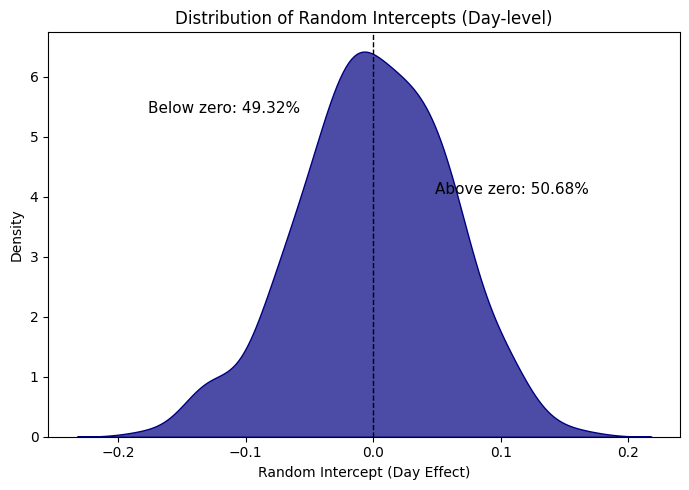

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# استخراج اثرات تصادفی (posterior mean)
b_samples = trace_weibull.posterior["b"].values.reshape(-1, n_groups)
b_mean = b_samples.mean(axis=0)

plt.figure(figsize=(7,5))
sns.kdeplot(b_mean, fill=True, color="navy", alpha=0.7)

plt.axvline(0, color="black", linestyle="--", linewidth=1)

p_below = (b_mean < 0).mean() * 100
p_above = (b_mean > 0).mean() * 100

plt.text(
    np.min(b_mean),
    plt.ylim()[1]*0.8,
    f"Below zero: {p_below:.2f}%",
    fontsize=11
)
plt.text(
    np.max(b_mean)*0.3,
    plt.ylim()[1]*0.6,
    f"Above zero: {p_above:.2f}%",
    fontsize=11
)

plt.xlabel("Random Intercept (Day Effect)")
plt.ylabel("Density")
plt.title("Distribution of Random Intercepts (Day-level)")
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import norm

summary = az.summary(trace_weibull, hdi_prob=0.95)

results = summary.loc[
    summary.index.str.contains("beta"),
    ["mean", "sd", "hdi_2.5%", "hdi_97.5%"]
].copy()

results["exp(beta)"] = np.exp(results["mean"])
results["z"] = results["mean"] / results["sd"]

# p-value دوطرفه
results["p_value"] = 2 * (1 - norm.cdf(np.abs(results["z"])))

results.index = X_train.columns
results


,mean,sd,hdi_2.5%,hdi_97.5%,exp(beta),z,p_value
سن بیمار,-0.006,0.004,-0.014,0.002,0.994018,-1.500000,1.336144e-01
جنسیت_مونث,0.006,0.009,-0.013,0.024,1.006018,0.666667,5.049851e-01
زمان شب و روز_شب,0.013,0.008,-0.002,0.030,1.013085,1.625000,1.041626e-01
نوع روز_اول هفته,0.022,0.013,-0.003,0.048,1.022244,1.692308,9.058732e-02
فصل_تابستان,0.185,0.024,0.138,0.233,1.203218,7.708333,1.265654e-14
فصل_زمستان,-0.139,0.024,-0.187,-0.091,0.870228,-5.791667,6.969135e-09
فصل_پاییز,0.016,0.025,-0.034,0.062,1.016129,0.640000,5.221726e-01
ساعت اوج ترافیک_خارج از اوج,-0.065,0.011,-0.087,-0.044,0.937067,-5.909091,3.440008e-09


In [ ]:
from scipy.stats import norm
import numpy as np
import arviz as az

# خلاصه پسین
summary = az.summary(trace_weibull, hdi_prob=0.95)

# استخراج ضرایب beta
results = summary.loc[
    summary.index.str.contains("beta"),
    ["mean", "sd", "hdi_2.5%", "hdi_97.5%"]
].copy()

# -------------------------
# برآوردها و آماره‌ها
# -------------------------

# برآورد نقطه‌ای ضریب (β̂)
results["beta_hat"] = results["mean"]

# نسبت زمان (AFT interpretation)
results["exp(beta)"] = np.exp(results["beta_hat"])

# آماره Wald
results["z"] = results["beta_hat"] / results["sd"]

# p-value دوطرفه (تقریبی)
results["p_value"] = 2 * (1 - norm.cdf(np.abs(results["z"])))


# نام‌گذاری سطرها با نام متغیرها
results.index = X_train.columns

# مرتب‌سازی ستون‌ها برای گزارش
results = results[
    ["beta_hat", "sd", "z", "p_value", "exp(beta)", "hdi_2.5%", "hdi_97.5%"]
]

results


,beta_hat,sd,z,p_value,exp(beta),hdi_2.5%,hdi_97.5%
سن بیمار,-0.006,0.004,-1.500000,1.336144e-01,0.994018,-0.014,0.002
جنسیت_مونث,0.006,0.009,0.666667,5.049851e-01,1.006018,-0.013,0.024
زمان شب و روز_شب,0.013,0.008,1.625000,1.041626e-01,1.013085,-0.002,0.030
نوع روز_اول هفته,0.022,0.013,1.692308,9.058732e-02,1.022244,-0.003,0.048
فصل_تابستان,0.185,0.024,7.708333,1.265654e-14,1.203218,0.138,0.233
فصل_زمستان,-0.139,0.024,-5.791667,6.969135e-09,0.870228,-0.187,-0.091
فصل_پاییز,0.016,0.025,0.640000,5.221726e-01,1.016129,-0.034,0.062
ساعت اوج ترافیک_خارج از اوج,-0.065,0.011,-5.909091,3.440008e-09,0.937067,-0.087,-0.044


In [ ]:
summary = az.summary(trace_weibull, hdi_prob=0.95)

results = summary.loc[
    summary.index.str.contains("beta"),
    ["mean", "sd", "hdi_2.5%", "hdi_97.5%"]
].copy()

results["exp(beta)"] = np.exp(results["mean"])
results["z"] = results["mean"] / results["sd"]
results["p_value"] = 2 * (1 - np.abs(results["z"]).apply(
    lambda x: 0.5 * (1 + np.math.erf(x / np.sqrt(2)))
))

results.index = X_train.columns
results


AttributeError: module 'numpy' has no attribute 'math'

In [ ]:
dist_params = summary.loc[
    ["mu", "sigma", "tau"],
    ["mean", "sd", "hdi_2.5%", "hdi_97.5%"]
]

dist_params


,mean,sd,hdi_2.5%,hdi_97.5%
mu,2.355,0.026,2.304,2.405
sigma,3.210,0.038,3.133,3.282
tau,0.079,0.006,0.068,0.092


In [ ]:
with pm.Model() as weibull_null:

    mu0 = pm.Normal("mu", 0, 10)
    k0 = pm.HalfNormal("k", 5)
    tau0 = pm.HalfNormal("tau", 5)
    b0 = pm.Normal("b", 0, tau0, shape=n_groups)

    lam0 = pm.math.exp(mu0 + b0[g_shared])

    pm.Weibull(
        "obs",
        alpha=k0,
        beta=lam0[observed],
        observed=t_train[observed]
    )

    trace_null = pm.sample(
        1000, tune=1000, target_accept=0.95,
        chains=2, cores=1, random_seed=42
    )


Output()

In [ ]:
logL_full = trace_weibull.sample_stats["lp"].mean().values
logL_null = trace_null.sample_stats["lp"].mean().values

LRT = - 2 * (logL_full - logL_null)
LRT


np.float64(20423.79194468088)

In [ ]:
# --------------------------------------------------------------
# Null Weibull AFT with Random Intercept
# --------------------------------------------------------------
with pm.Model() as weibull_null:

    # پارامترهای Null
    mu0 = pm.Normal("mu", 0, 10)
    k0 = pm.HalfNormal("k", 5)      # shape parameter
    tau0 = pm.HalfNormal("tau", 5)
    b0 = pm.Normal("b", 0, tau0, shape=n_groups)

    # اثر خطی با اثر تصادفی روز
    lin_pred0 = mu0 + b0[g_train]
    lam0 = pm.math.exp(lin_pred0)   # scale parameter λ

    # likelihood برای مشاهده‌شده‌ها
    pm.Weibull("obs", alpha=k0, beta=lam0[observed], observed=t_train[observed])

    # سانسورشده‌ها: S(t) = exp(-(t/λ)^k)
    if np.any(~observed):
        ratio = t_train[~observed] / lam0[~observed]
        survival = pm.math.exp(-(ratio ** k0))
        pm.Potential("cens", pm.math.log(survival))

    # نمونه‌گیری
    trace_null_wb = pm.sample(
        1000, tune=1000, chains=2, cores=1,
        target_accept=0.95, random_seed=42
    )

# --------------------------------------------------------------
# Likelihood Ratio Test (Null vs Full)
# --------------------------------------------------------------
logL_full = trace_weibull.sample_stats["lp"].mean().values
logL_null = trace_null_wb.sample_stats["lp"].mean().values

LRT_wb = 2 * (logL_full - logL_null)
print(f"\nLikelihood Ratio Test (Weibull Null vs Full): {LRT_wb:.4f}")


Output()


Likelihood Ratio Test (Weibull Null vs Full): 368.9748


In [ ]:

"""
Random Intercept Accelerated Failure Time Model
(Log-Logistic / Fisk distribution)
Censoring: durations > 8 minutes
Random intercept for day ('تاریخ')
"""

# --------------------------------------------------------------
# 1. Libraries
# --------------------------------------------------------------
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.special import gamma

# --------------------------------------------------------------
# 2. Data Preparation
# --------------------------------------------------------------


columns_to_drop = [
    "ID", "Accident_ID",
    "زمان تماس", "ساعت رسیدن به محل حادثه"
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)

# --- انتخاب X و y ---
X_cols = ["سن بیمار", "جنسیت", "زمان شب و روز", "نوع روز",  "فصل", "ساعت اوج ترافیک"]
X = df[X_cols].copy()
y = df[["مدت زمان", "وضعیت"]].copy()

# --- پیش‌پردازش ---
categorical_cols = ["جنسیت", "زمان شب و روز", "نوع روز",  "فصل", "ساعت اوج ترافیک"]
X_categorical = pd.get_dummies(X[categorical_cols], drop_first=True)

scaler = StandardScaler()
X_numeric = pd.DataFrame(scaler.fit_transform(X[["سن بیمار"]]), columns=["سن بیمار"], index=X.index)

X_processed = pd.concat([X_numeric, X_categorical], axis=1)

# --- گروه‌بندی بر اساس تاریخ ---
date_col = df["تاریخ"].copy()
group_factor, _ = pd.factorize(date_col)
group_factor = group_factor.astype(np.int32)

# --- تقسیم داده ---
X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
    X_processed, y, group_factor, test_size=0.2, random_state=42, stratify=y["وضعیت"]
)

# --- اطمینان از عددی بودن ---
X_train = X_train.apply(pd.to_numeric, errors='coerce').astype(float)
y_train["مدت زمان"] = pd.to_numeric(y_train["مدت زمان"], errors='coerce')
y_train["وضعیت"] = pd.to_numeric(y_train["وضعیت"], errors='coerce')

print(f"تعداد نمونه کل: {len(df)}")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# --------------------------------------------------------------
# 3. Training Data Setup
# --------------------------------------------------------------
t_train = np.where(y_train["وضعیت"] == 1, y_train["مدت زمان"].values, 8.0)
observed = (y_train["وضعیت"] == 1).values
unique_groups = np.unique(g_train)
n_groups = len(unique_groups)

# --------------------------------------------------------------
# 4. توابع لگ‌لوجستیک (Fisk)
# --------------------------------------------------------------
def loglogistic_logpdf(t, alpha, sigma):
    """Log of PDF for Log-Logistic (Fisk)"""
    z = (t / alpha) ** sigma
    return pm.math.log(sigma) - pm.math.log(alpha) + (sigma - 1) * pm.math.log(t / alpha) - 2 * pt.log1p(z)

def loglogistic_logsf(t, alpha, sigma):
    """Log of Survival Function"""
    z = (t / alpha) ** sigma
    return -pt.log1p(z)

# --------------------------------------------------------------
# 5. Log-Logistic AFT with Random Intercept
# --------------------------------------------------------------
with pm.Model() as loglogistic_aft:
    # پارامترها
    mu = pm.Normal("mu", 0, 10)
    beta = pm.Normal("beta", 0, 10, shape=X_train.shape[1])
    sigma = pm.HalfNormal("sigma", 5)   # shape parameter
    tau = pm.HalfNormal("tau", 5)       # variance of random effect
    b = pm.Normal("b", 0, tau, shape=n_groups)

    # پیش‌بینی خطی
    lin_pred = mu + pm.math.dot(X_train, beta) + b[g_train]
    alpha = pm.Deterministic("alpha", pm.math.exp(lin_pred))

    # --- احتمال داده‌های مشاهده‌شده ---
    logp_obs = loglogistic_logpdf(t_train[observed], alpha[observed], sigma)
    pm.Potential("obs", pm.math.sum(logp_obs))

    # --- داده‌های سانسور شده ---
    if np.any(~observed):
        logsf_cens = loglogistic_logsf(t_train[~observed], alpha[~observed], sigma)
        pm.Potential("cens", pm.math.sum(logsf_cens))

    # نمونه‌گیری
    trace_llog = pm.sample(1000, tune=1000, target_accept=0.9, chains=2, cores=1, random_seed=42)

# --------------------------------------------------------------
# 6. ارزیابی مدل (AIC, MAE, MAPE)
# --------------------------------------------------------------
summary = az.summary(trace_llog, kind="stats")
mean_vals = summary["mean"].to_dict()

beta_hat = np.array([mean_vals[f"beta[{i}]"] for i in range(X_train.shape[1])])
mu_hat = mean_vals["mu"]
sigma_hat = mean_vals["sigma"]
b_hat = np.array([mean_vals[f"b[{i}]"] for i in range(n_groups)])

lin_pred = mu_hat + X_train.values @ beta_hat + b_hat[g_train]
alpha_hat = np.exp(lin_pred)

# --- Log-likelihood برای AIC ---
z = (t_train / alpha_hat) ** sigma_hat
logpdf = np.log(sigma_hat) - np.log(alpha_hat) + (sigma_hat - 1) * np.log(t_train / alpha_hat) - 2 * np.log1p(z)
logsf = -np.log1p(z)
logL = np.sum(logpdf[observed]) + np.sum(logsf[~observed])
k = X_train.shape[1] + 3 + n_groups
aic_llog = 2 * k - 2 * logL

# --- پیش‌بینی میانگین ---
pred_mean = alpha_hat * (np.pi / sigma_hat) / np.sin(np.pi / sigma_hat)

obs_idx = (y_train["وضعیت"] == 1).values
mae = mean_absolute_error(y_train["مدت زمان"].values[obs_idx], pred_mean[obs_idx])
mape = mean_absolute_percentage_error(y_train["مدت زمان"].values[obs_idx], pred_mean[obs_idx])

# --------------------------------------------------------------
# 7. گزارش نهایی
# --------------------------------------------------------------
print("\n" + "="*60)
print("📊 Random Intercept Log-Logistic AFT (Fisk) Results")
print("="*60)
print(f"Total samples: {len(X_train)} | Groups (days): {n_groups}")
print(f"AIC  : {aic_llog:.2f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.4f}")
print("="*60)

# --------------------------------------------------------------
# 8. چاپ برآورد پارامترها
# --------------------------------------------------------------
print("\n📌 Parameter Estimates for Log-Logistic AFT (Fisk)\n")

# mu
print(f"mu     : {mean_vals['mu']:.4f}")

# beta‌ها
for i, col in enumerate(X_train.columns):
    print(f"beta[{col}] : {mean_vals[f'beta[{i}]']:.4f}")

# sigma
print(f"sigma  : {mean_vals['sigma']:.4f}")

# tau (variance of random intercept)
print(f"tau    : {mean_vals['tau']:.4f}")

# b‌ها (random intercept per group/day)
print("b (random intercepts per group):")
for i in range(n_groups):
    print(f" b[{i}] : {mean_vals[f'b[{i}]']:.4f}")

تعداد نمونه کل: 22103
X_train: (17682, 8), X_test: (4421, 8)
y_train: (17682, 2), y_test: (4421, 2)


Output()


📊 Random Intercept Log-Logistic AFT (Fisk) Results
Total samples: 17682 | Groups (days): 294
AIC  : 42216.35
MAE  : 4.6079
MAPE : 0.9632

📌 Parameter Estimates for Log-Logistic AFT (Fisk)

mu     : 2.2710
beta[سن بیمار] : -0.0070
beta[جنسیت_مونث] : 0.0070
beta[زمان شب و روز_شب] : 0.0190
beta[نوع روز_اول هفته] : 0.0220
beta[فصل_تابستان] : 0.1900
beta[فصل_زمستان] : -0.1770
beta[فصل_پاییز] : 0.0140
beta[ساعت اوج ترافیک_خارج از اوج] : -0.0730
sigma  : 3.6330
tau    : 0.0880
b (random intercepts per group):
 b[0] : 0.0550
 b[1] : -0.0350
 b[2] : -0.0350
 b[3] : -0.0760
 b[4] : -0.0510
 b[5] : 0.0730
 b[6] : 0.0630
 b[7] : -0.0050
 b[8] : -0.0120
 b[9] : -0.0200
 b[10] : -0.0160
 b[11] : -0.0310
 b[12] : -0.0100
 b[13] : 0.0480
 b[14] : 0.0580
 b[15] : 0.0110
 b[16] : -0.0220
 b[17] : -0.0240
 b[18] : 0.0320
 b[19] : 0.0100
 b[20] : 0.0430
 b[21] : -0.0620
 b[22] : 0.0190
 b[23] : -0.0380
 b[24] : -0.0860
 b[25] : -0.0210
 b[26] : 0.0260
 b[27] : 0.0250
 b[28] : 0.0010
 b[29] : -0.0360
 b[3

In [ ]:
# --------------------------------------------------------------
# 9. ارزیابی روی داده تست
# --------------------------------------------------------------


X_test = X_test.apply(pd.to_numeric, errors='coerce').astype(float)
b_hat = np.array(b_hat, dtype=float)
g_test = np.array(g_test, dtype=int)

# --- آماده‌سازی داده تست ---
t_test = np.where(y_test["وضعیت"] == 1, y_test["مدت زمان"].values, 8.0)
observed_test = (y_test["وضعیت"] == 1).values

# --- محاسبه پیش‌بینی‌ها با پارامترهای برآوردشده ---
lin_pred_test = mu_hat + X_test.values @ beta_hat + b_hat[g_test]
alpha_test = np.exp(lin_pred_test)

# --- میانگین زمان پیش‌بینی‌شده بر اساس توزیع Log-Logistic ---
pred_mean_test = alpha_test * (np.pi / sigma_hat) / np.sin(np.pi / sigma_hat)

# --- محاسبه MAE و MAPE فقط برای داده‌های غیرسانسور ---
obs_idx_test = observed_test
mae_test = mean_absolute_error(y_test["مدت زمان"].values[obs_idx_test], pred_mean_test[obs_idx_test])
mape_test = mean_absolute_percentage_error(y_test["مدت زمان"].values[obs_idx_test], pred_mean_test[obs_idx_test])

print("\n" + "="*60)
print("📊 Evaluation on Test Data")
print("="*60)
print(f"MAE  (Test): {mae_test:.4f}")
print(f"MAPE (Test): {mape_test:.4f}")
print("="*60)



📊 Evaluation on Test Data
MAE  (Test): 4.6701
MAPE (Test): 0.9536


In [ ]:
with pm.Model() as llog_null:

    # پارامترهای Null
    mu0 = pm.Normal("mu", 0, 10)
    sigma0 = pm.HalfNormal("sigma", 5)
    tau0 = pm.HalfNormal("tau", 5)
    b0 = pm.Normal("b", 0, tau0, shape=n_groups)

    # لگاریتمی اثر خطی با اثر تصادفی روز
    lin_pred0 = mu0 + b0[g_shared]
    alpha0 = pm.Deterministic("alpha", pm.math.exp(lin_pred0))

    # احتمال مشاهده‌شده‌ها
    pm.Potential(
        "obs",
        pt.sum(loglogistic_logpdf(t_train[observed], alpha0[observed], sigma0))
    )

    # احتمال سانسورشده‌ها
    if np.any(~observed):
        pm.Potential(
            "cens",
            pt.sum(loglogistic_logsf(t_train[~observed], alpha0[~observed], sigma0))
        )

    trace_null = pm.sample(
        1000, tune=1000, chains=2, cores=1,
        target_accept=0.95, random_seed=42
    )




Output()


Likelihood Ratio Test (Log-Logistic Null vs Full): -380.7822


In [ ]:
# محاسبه Likelihood Ratio Test
logL_full = trace_llog.sample_stats["lp"].mean().values
logL_null = trace_null.sample_stats["lp"].mean().values

LRT = 2 * (logL_full - logL_null)
print(f"\nLikelihood Ratio Test (Log-Logistic Null vs Full): {LRT:.4f}")


Likelihood Ratio Test (Log-Logistic Null vs Full): 380.7822


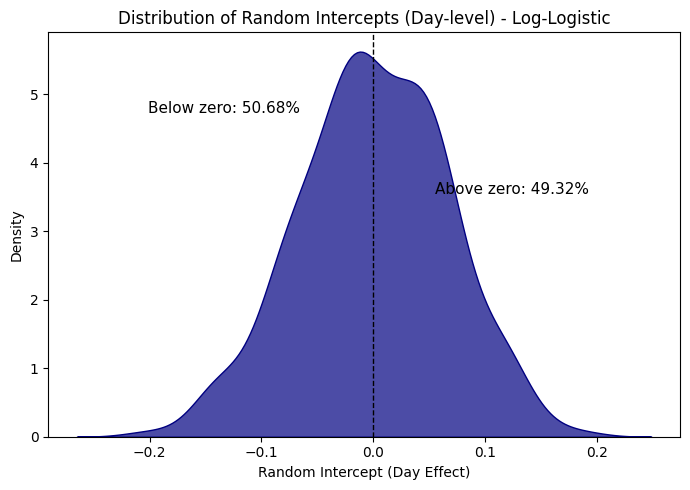

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# استخراج اثرات تصادفی posterior mean
b_samples = trace_llog.posterior["b"].values.reshape(-1, n_groups)
b_mean = b_samples.mean(axis=0)

plt.figure(figsize=(7,5))
sns.kdeplot(b_mean, fill=True, color="navy", alpha=0.7)

plt.axvline(0, color="black", linestyle="--", linewidth=1)

p_below = (b_mean < 0).mean() * 100
p_above = (b_mean > 0).mean() * 100

plt.text(
    np.min(b_mean),
    plt.ylim()[1]*0.8,
    f"Below zero: {p_below:.2f}%",
    fontsize=11
)
plt.text(
    np.max(b_mean)*0.3,
    plt.ylim()[1]*0.6,
    f"Above zero: {p_above:.2f}%",
    fontsize=11
)

plt.xlabel("Random Intercept (Day Effect)")
plt.ylabel("Density")
plt.title("Distribution of Random Intercepts (Day-level) - Log-Logistic")
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import norm

summary = az.summary(trace_llog, hdi_prob=0.95)

# پارامترهای ثابت (beta)
results = summary.loc[
    summary.index.str.contains("beta"),
    ["mean", "sd", "hdi_2.5%", "hdi_97.5%"]
].copy()

results["exp(beta)"] = np.exp(results["mean"])
results["z"] = results["mean"] / results["sd"]
results["p_value"] = 2 * (1 - norm.cdf(np.abs(results["z"])))

results.index = X_train.columns
print("\n📌 Fixed Effects Summary (beta):\n")
print(results)

# پارامترهای توزیع و اثر تصادفی
dist_params = summary.loc[
    ["mu", "sigma", "tau"],
    ["mean", "sd", "hdi_2.5%", "hdi_97.5%"]
]
print("\n📌 Distribution & Random Effect Parameters:\n")
print(dist_params)



📌 Fixed Effects Summary (beta):

                              mean     sd  hdi_2.5%  hdi_97.5%  exp(beta)  \
سن بیمار                    -0.007  0.004    -0.015      0.001   0.993024   
جنسیت_مونث                   0.007  0.010    -0.014      0.026   1.007025   
زمان شب و روز_شب             0.019  0.009     0.003      0.036   1.019182   
نوع روز_اول هفته             0.022  0.015    -0.006      0.051   1.022244   
فصل_تابستان                  0.190  0.026     0.139      0.241   1.209250   
فصل_زمستان                  -0.177  0.027    -0.227     -0.123   0.837780   
فصل_پاییز                    0.014  0.027    -0.038      0.066   1.014098   
ساعت اوج ترافیک_خارج از اوج -0.073  0.012    -0.095     -0.050   0.929601   

                                    z       p_value  
سن بیمار                    -1.750000  8.011831e-02  
جنسیت_مونث                   0.700000  4.839273e-01  
زمان شب و روز_شب             2.111111  3.476276e-02  
نوع روز_اول هفته             1.466667  1.424668e-01  
فص

In [ ]:

"""
Random Intercept Accelerated Failure Time Model
for Emergency Response Data (Weibull & LogNormal)
Censoring: durations > 8 minutes
"""

# --------------------------------------------------------------
# 1. Libraries
# --------------------------------------------------------------
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import lognorm, weibull_min
from scipy.special import gamma

# --------------------------------------------------------------
# 2. Data Preparation
# --------------------------------------------------------------


# --- حذف ستون‌های غیرضروری ---
columns_to_drop = [
    "ID", "Accident_ID", "تعداد تصادف" ,
    "زمان تماس", "ساعت رسیدن به محل حادثه"
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)

# --- انتخاب X و y ---
X_cols = ["سن بیمار", "جنسیت", "زمان شب و روز", "نوع روز",  "فصل", "ساعت اوج ترافیک"]
X = df[X_cols].copy()
y = df[["مدت زمان", "وضعیت"]].copy()

# --- پیش‌پردازش ---
categorical_cols = ["جنسیت", "زمان شب و روز", "نوع روز","فصل", "ساعت اوج ترافیک"]
X_categorical = pd.get_dummies(X[categorical_cols], drop_first=True)

scaler = StandardScaler()
X_numeric = pd.DataFrame(scaler.fit_transform(X[["سن بیمار"]]), columns=["سن بیمار"], index=X.index)

X_processed = pd.concat([X_numeric, X_categorical], axis=1)

# --- گروه‌بندی تاریخ‌ها ---
date_col = df["تاریخ"].copy()
group_factor, _ = pd.factorize(date_col)
group_factor = group_factor.astype(np.int32)

# --- تقسیم داده ---
X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(
    X_processed, y, group_factor, test_size=0.2, random_state=42, stratify=y["وضعیت"]
)

# --- اطمینان از عددی بودن همه ورودی‌ها ---
X_train = X_train.apply(pd.to_numeric, errors='coerce').astype(float)
y_train["مدت زمان"] = pd.to_numeric(y_train["مدت زمان"], errors='coerce')
y_train["وضعیت"] = pd.to_numeric(y_train["وضعیت"], errors='coerce')

print(f"تعداد نمونه کل: {len(df)}")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# --------------------------------------------------------------
# 3. Training Data Setup
# --------------------------------------------------------------
t_train = np.where(y_train["وضعیت"] == 1, y_train["مدت زمان"].values, 8.0)
observed = (y_train["وضعیت"] == 1).values
unique_groups = np.unique(g_train)
n_groups = len(unique_groups)

# --------------------------------------------------------------
# 4. Helper function for AIC, MAE, MAPE
# --------------------------------------------------------------
def evaluate_aft(distribution_name, trace, X_train, g_train, y_train, t_train, observed, n_groups):
    summary = az.summary(trace, kind="stats")
    mean_vals = summary["mean"].to_dict()

    beta_hat = np.array([mean_vals[f"beta[{i}]"] for i in range(X_train.shape[1])])
    mu_hat = mean_vals["mu"]
    sigma_hat = mean_vals["sigma"]
    b_hat = np.array([mean_vals[f"b[{i}]"] for i in range(n_groups)])

    lin_pred = mu_hat + X_train @ beta_hat + b_hat[g_train]

    # ---- AIC ----
    if distribution_name == "lognormal":
        scale = np.exp(lin_pred)
        logpdf = lognorm.logpdf(t_train[observed], s=sigma_hat, scale=scale[observed])
        logsf = lognorm.logsf(t_train[~observed], s=sigma_hat, scale=scale[~observed])
    elif distribution_name == "weibull":
        alpha = np.exp(lin_pred)
        kappa = sigma_hat
        logpdf = weibull_min.logpdf(t_train[observed], c=kappa, scale=alpha[observed])
        logsf = weibull_min.logsf(t_train[~observed], c=kappa, scale=alpha[~observed])
    else:
        raise ValueError("Unknown distribution")

    logL = np.sum(logpdf) + np.sum(logsf)
    k = X_train.shape[1] + 3 + n_groups
    aic = 2 * k - 2 * logL

    # ---- MAE / MAPE ----
    if distribution_name == "lognormal":
        pred_mean = np.exp(lin_pred + (sigma_hat**2) / 2)
    elif distribution_name == "weibull":
        pred_mean = np.exp(lin_pred) * gamma(1 + 1 / sigma_hat)

    obs_idx = (y_train["وضعیت"] == 1).values
    valid_idx = y_train["مدت زمان"].values[obs_idx] > 1.0
    mae = mean_absolute_error(y_train["مدت زمان"].values[obs_idx][valid_idx],
                              pred_mean[obs_idx][valid_idx])
    mape = mean_absolute_percentage_error(y_train["مدت زمان"].values[obs_idx][valid_idx],
                                          pred_mean[obs_idx][valid_idx])

    return aic, mae, mape

# --------------------------------------------------------------
# 5. Log-Normal AFT with Random Intercept
# --------------------------------------------------------------
with pm.Model() as lognormal_aft:
    mu = pm.Normal("mu", 0, 10)
    beta = pm.Normal("beta", 0, 10, shape=X_train.shape[1])
    sigma = pm.HalfNormal("sigma", 5)
    tau = pm.HalfNormal("tau", 5)
    b = pm.Normal("b", 0, tau, shape=n_groups)

    lin_pred = mu + pm.math.dot(X_train, beta) + b[g_train]

    # Likelihood for observed (non-censored)
    pm.Lognormal("obs", mu=lin_pred[observed], sigma=sigma, observed=t_train[observed])

    # سانسور: S(t) = 1 - Phi( (ln t - mu_i) / sigma )
    if np.any(~observed):
        # z = (ln t - mu_i) / sigma
        z = (pm.math.log(t_train[~observed]) - lin_pred[~observed]) / sigma
        # Phi(z) = 0.5*(1 + erf(z / sqrt(2)))  => S = 1 - Phi = 0.5*(1 - erf(...))
        one_minus_phi = 0.5 * (1 - pm.math.erf(z / pm.math.sqrt(2.0)))
        # برای ایمنی عددی، مقدار حداقلی (epsilon) قرار می‌دیم تا log(0) رخ ندهد
        eps = 1e-12
        logsf = pm.math.log(pm.math.maximum(one_minus_phi, eps))
        pm.Potential("cens", logsf)

    trace_lognormal = pm.sample(1000, tune=1000, target_accept=0.9,
                                chains=2, cores=1, random_seed=42)


aic_ln, mae_ln, mape_ln = evaluate_aft("lognormal", trace_lognormal, X_train.values, g_train, y_train, t_train, observed, n_groups)

تعداد نمونه کل: 22103
X_train: (17682, 8), X_test: (4421, 8)
y_train: (17682, 2), y_test: (4421, 2)


Output()

In [ ]:


# --------------------------------------------------------------
# 7. Final Report
# --------------------------------------------------------------
print("\n" + "="*60)
print("📊 Random Intercept AFT Results")
print("="*60)
print(f"Total samples: {len(X_train)} | Groups (days): {n_groups}")
print("------ Log-Normal AFT ------")
print(f"AIC  : {aic_ln:.2f}")
print(f"MAE  : {mae_ln:.4f}")
print(f"MAPE : {mape_ln:.4f}")


# --------------------------------------------------------------
# 7. Final Report with Parameter Estimates
# --------------------------------------------------------------

def print_parameter_estimates(trace, X_train, n_groups, model_name="Model"):
    summary = az.summary(trace, kind="stats")
    print(f"\n📌 Parameter estimates for {model_name}:\n")
    # mu
    print(f"mu     : {summary.loc['mu', 'mean']:.4f}")
    # beta
    for i, col in enumerate(X_train.columns):
        print(f"beta[{col}] : {summary.loc[f'beta[{i}]', 'mean']:.4f}")
    # sigma / kappa
    if 'sigma' in summary.index:
        print(f"sigma  : {summary.loc['sigma', 'mean']:.4f}")
    if 'kappa' in summary.index:
        print(f"kappa  : {summary.loc['sigma', 'mean']:.4f}")  # در مدل Weibull sigma همان kappa است
    # tau
    print(f"tau    : {summary.loc['tau', 'mean']:.4f}")
    # random intercepts b
    print("b (random intercepts per group):")
    for i in range(n_groups):
        print(f" b[{i}] : {summary.loc[f'b[{i}]', 'mean']:.4f}")

# چاپ نتایج LogNormal
print_parameter_estimates(trace_lognormal, X_train, n_groups, model_name="LogNormal AFT")


📊 Random Intercept AFT Results
Total samples: 17682 | Groups (days): 294
------ Log-Normal AFT ------
AIC  : 42359.87
MAE  : 5.1343
MAPE : 1.0538

📌 Parameter estimates for LogNormal AFT:

mu     : 2.3220
beta[سن بیمار] : -0.0070
beta[جنسیت_مونث] : 0.0080
beta[زمان شب و روز_شب] : 0.0260
beta[نوع روز_اول هفته] : 0.0200
beta[فصل_تابستان] : 0.2050
beta[فصل_زمستان] : -0.2170
beta[فصل_پاییز] : 0.0150
beta[ساعت اوج ترافیک_خارج از اوج] : -0.0800
sigma  : 0.5250
tau    : 0.1000
b (random intercepts per group):
 b[0] : 0.0540
 b[1] : -0.0220
 b[2] : -0.0390
 b[3] : -0.0780
 b[4] : -0.0490
 b[5] : 0.0850
 b[6] : 0.0760
 b[7] : -0.0090
 b[8] : -0.0140
 b[9] : -0.0230
 b[10] : -0.0070
 b[11] : -0.0300
 b[12] : -0.0040
 b[13] : -0.0030
 b[14] : 0.0730
 b[15] : 0.0130
 b[16] : -0.0200
 b[17] : -0.0170
 b[18] : 0.0270
 b[19] : 0.0140
 b[20] : 0.0550
 b[21] : -0.0800
 b[22] : 0.0310
 b[23] : -0.0400
 b[24] : -0.1460
 b[25] : -0.0150
 b[26] : 0.0290
 b[27] : 0.0270
 b[28] : -0.0040
 b[29] : -0.0330
 b

In [ ]:
# --------------------------------------------------------------
# 8. Evaluation on Test Data
# --------------------------------------------------------------
from math import pi, sin

def evaluate_test_data(distribution_name, trace, X_test, g_test, y_test, n_groups):
    """Compute mean predicted duration, MAE, and MAPE on test set."""
    summary = az.summary(trace, kind="stats")
    mean_vals = summary["mean"].to_dict()

    # استخراج پارامترهای میانگین از نمونه‌ها
    beta_hat = np.array([mean_vals[f"beta[{i}]"] for i in range(X_test.shape[1])])
    mu_hat = mean_vals["mu"]
    sigma_hat = mean_vals["sigma"]
    b_hat = np.array([mean_vals[f"b[{i}]"] for i in range(n_groups)])

    # داده‌ها را عددی و ایمن تبدیل کن
    X_test = X_test.apply(pd.to_numeric, errors='coerce').astype(float)
    g_test = np.array(g_test, dtype=int)
    y_test["مدت زمان"] = pd.to_numeric(y_test["مدت زمان"], errors='coerce')
    y_test["وضعیت"] = pd.to_numeric(y_test["وضعیت"], errors='coerce')

    # سانسور: بیشتر از 8 دقیقه
    t_test = np.where(y_test["وضعیت"] == 1, y_test["مدت زمان"].values, 8.0)
    observed_test = (y_test["وضعیت"] == 1).values

    # پیش‌بینی میانگین زمان بر اساس توزیع
    lin_pred_test = mu_hat + X_test.values @ beta_hat + b_hat[g_test]

    if distribution_name == "lognormal":
        pred_mean_test = np.exp(lin_pred_test + (sigma_hat**2) / 2)

    else:
        raise ValueError("Unknown distribution")

    # فقط داده‌های غیرسانسور برای ارزیابی
    obs_idx_test = observed_test
    mae_test = mean_absolute_error(y_test["مدت زمان"].values[obs_idx_test],
                                   pred_mean_test[obs_idx_test])
    mape_test = mean_absolute_percentage_error(y_test["مدت زمان"].values[obs_idx_test],
                                               pred_mean_test[obs_idx_test])

    return mae_test, mape_test, pred_mean_test

# ارزیابی برای مدل LogNormal
mae_ln_test, mape_ln_test, preds_ln = evaluate_test_data("lognormal", trace_lognormal, X_test, g_test, y_test, n_groups)


# --------------------------------------------------------------
# 9. گزارش نهایی
# --------------------------------------------------------------
print("\n" + "="*70)
print("📊 Final Evaluation on Test Data")
print("="*70)
print("------ Log-Normal AFT ------")
print(f"MAE (Test):  {mae_ln_test:.4f}")
print(f"MAPE (Test): {mape_ln_test:.4f}")


📊 Final Evaluation on Test Data
------ Log-Normal AFT ------
MAE (Test):  5.2167
MAPE (Test): 1.0496


In [ ]:
with pm.Model() as lognormal_null:

    # پارامترهای Null
    mu0 = pm.Normal("mu", 0, 10)
    sigma0 = pm.HalfNormal("sigma", 5)
    tau0 = pm.HalfNormal("tau", 5)
    b0 = pm.Normal("b", 0, tau0, shape=n_groups)

    # لگاریتم اثر خطی با اثر تصادفی روز
    lin_pred0 = mu0 + b0[g_train]

    # مشاهده‌شده‌ها
    pm.Lognormal("obs", mu=lin_pred0[observed], sigma=sigma0, observed=t_train[observed])

    # سانسورشده‌ها
    if np.any(~observed):
        z = (pm.math.log(t_train[~observed]) - lin_pred0[~observed]) / sigma0
        one_minus_phi = 0.5 * (1 - pm.math.erf(z / pm.math.sqrt(2.0)))
        eps = 1e-12
        logsf = pm.math.log(pm.math.maximum(one_minus_phi, eps))
        pm.Potential("cens", logsf)

    trace_null_ln = pm.sample(1000, tune=1000, chains=2, cores=1,
                              target_accept=0.9, random_seed=42)

# محاسبه Likelihood Ratio Test
logL_full = trace_lognormal.sample_stats["lp"].mean().values
logL_null = trace_null_ln.sample_stats["lp"].mean().values

LRT_ln = 2 * (logL_full - logL_null)
print(f"\nLikelihood Ratio Test (Log-Normal Null vs Full): {LRT_ln:.4f}")


Output()


Likelihood Ratio Test (Log-Normal Null vs Full): 385.8032


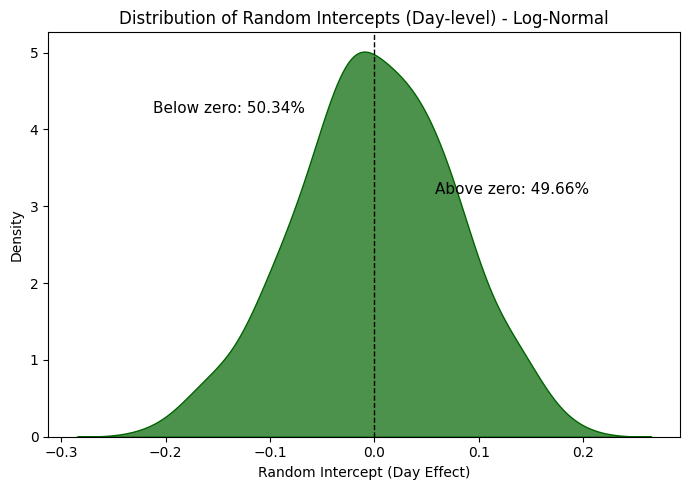

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# استخراج اثرات تصادفی posterior mean
b_samples_ln = trace_lognormal.posterior["b"].values.reshape(-1, n_groups)
b_mean_ln = b_samples_ln.mean(axis=0)

plt.figure(figsize=(7,5))
sns.kdeplot(b_mean_ln, fill=True, color="darkgreen", alpha=0.7)

plt.axvline(0, color="black", linestyle="--", linewidth=1)

p_below = (b_mean_ln < 0).mean() * 100
p_above = (b_mean_ln > 0).mean() * 100

plt.text(
    np.min(b_mean_ln),
    plt.ylim()[1]*0.8,
    f"Below zero: {p_below:.2f}%",
    fontsize=11
)
plt.text(
    np.max(b_mean_ln)*0.3,
    plt.ylim()[1]*0.6,
    f"Above zero: {p_above:.2f}%",
    fontsize=11
)

plt.xlabel("Random Intercept (Day Effect)")
plt.ylabel("Density")
plt.title("Distribution of Random Intercepts (Day-level) - Log-Normal")
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import norm

summary_ln = az.summary(trace_lognormal, hdi_prob=0.95)

# پارامترهای ثابت (beta)
results_ln = summary_ln.loc[
    summary_ln.index.str.contains("beta"),
    ["mean", "sd", "hdi_2.5%", "hdi_97.5%"]
].copy()

results_ln["exp(beta)"] = np.exp(results_ln["mean"])
results_ln["z"] = results_ln["mean"] / results_ln["sd"]
results_ln["p_value"] = 2 * (1 - norm.cdf(np.abs(results_ln["z"])))

results_ln.index = X_train.columns
print("\n📌 Fixed Effects Summary (beta) - Log-Normal:\n")
print(results_ln)

# پارامترهای توزیع و اثر تصادفی
dist_params_ln = summary_ln.loc[
    ["mu", "sigma", "tau"],
    ["mean", "sd", "hdi_2.5%", "hdi_97.5%"]
]
print("\n📌 Distribution & Random Effect Parameters - Log-Normal:\n")
print(dist_params_ln)



📌 Fixed Effects Summary (beta) - Log-Normal:

                              mean     sd  hdi_2.5%  hdi_97.5%  exp(beta)  \
سن بیمار                    -0.007  0.005    -0.016      0.003   0.993024   
جنسیت_مونث                   0.008  0.011    -0.012      0.030   1.008032   
زمان شب و روز_شب             0.026  0.010     0.006      0.046   1.026341   
نوع روز_اول هفته             0.020  0.017    -0.011      0.053   1.020201   
فصل_تابستان                  0.205  0.032     0.147      0.272   1.227525   
فصل_زمستان                  -0.217  0.032    -0.280     -0.155   0.804930   
فصل_پاییز                    0.015  0.032    -0.045      0.079   1.015113   
ساعت اوج ترافیک_خارج از اوج -0.080  0.013    -0.105     -0.054   0.923116   

                                    z       p_value  
سن بیمار                    -1.400000  1.615133e-01  
جنسیت_مونث                   0.727273  4.670589e-01  
زمان شب و روز_شب             2.600000  9.322376e-03  
نوع روز_اول هفته             1.176471  2.39

In [ ]:
!pip install arabic-reshaper python-bidi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 9.9 MB/s eta 0:00:00
